In [1]:
import numpy as np
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from utils import progressBar
from metrics import Metric

import data_utils
from mdp import MDP
from rewards import reward_func_linear, reward_func_decay, reward_func_simple_decay  # Call it with stats to initialize
from env import Env
from q_learning import QLearningAlgo
from regression import RegressionAlgo
from parameterSchedulers import linearScheduler
from policy import EpsilonGreedyPolicy, GreedyPolicy, AlwaysDoPolicy, RandomPolicy, PositiveRewardPolicy

Using TensorFlow backend.


In [2]:
data = data_utils.Data(small=False)

100%|██████████| 53/53 [00:26<00:00,  1.42it/s]


In [11]:
config = {'init_cost' : 0.4,
          'discount' : 0.25,
          'q_epochs' : 3,
          'r_epochs' : 3,
          'q_policy' : EpsilonGreedyPolicy(action_space = MDP.action_space, epsilon_scheduler=linearScheduler(1.,c=1,k=0.0008)),
#           'q_policy' : RandomPolicy(action_space = MDP.action_space),
          'r_policy' : RandomPolicy(action_space = MDP.action_space),
          'test_policy': GreedyPolicy(action_space = MDP.action_space)}

In [12]:
# Markov decision process for each algorithm
mdp_Q = MDP(data=data)
mdp_R = MDP(data=data)

# Reward functions
reward_func = reward_func_simple_decay(data.statistics, verbose=False, init_cost = config['init_cost'])

# Environment 
env = Env(reward_func=reward_func, mode = 'machine')

In [13]:
# Algos
algo_Q = QLearningAlgo(mdp= mdp_Q, env = env, policy = config['q_policy'], discount = config['discount'])
algo_R = RegressionAlgo(mdp = mdp_R, env = env, policy = config['r_policy'])

In [14]:
# Ftting functions for each algo
def fit_R(epochs = 3):
    algo_R.collect_data(n = 3)
    algo_R.fit(epochs = epochs)

def fit_Q(epochs = 1):
    for i in range(epochs):
        algo_Q.fit(epochs = 1, remember=True)
        algo_Q.replay(batch_size=16, epochs = 1)

# Testing function
def test(algo, policy, visual = False):
    algo.test(policy = policy, visualize = visual)

In [15]:
fit_R(epochs = config['r_epochs'])
test(algo_R, policy = config['test_policy'])

100%|██████████| 129030/129030 [00:14<00:00, 9005.29it/s] 


Epoch 1/3
129030/129030 [==============================] - 25s 195us/step - loss: 0.1483
Epoch 2/3
129030/129030 [==============================] - 27s 213us/step - loss: 0.1099
Epoch 3/3
129030/129030 [==============================] - 27s 208us/step - loss: 0.1045


100%|██████████| 8135/8135 [00:03<00:00, 2357.81it/s]


Testing accumulated reward : 402.0294056087815


In [16]:
fit_Q(epochs=config['q_epochs'])
test(algo_Q, policy = config['test_policy'])

100%|██████████| 43010/43010 [01:57<00:00, 367.24it/s]


Training accumulated reward : -13559.103091822455
Epoch 1/1


100%|██████████| 43010/43010 [01:58<00:00, 362.69it/s]


Training accumulated reward : -21178.15112389508
Epoch 1/1


100%|██████████| 43010/43010 [01:54<00:00, 376.10it/s]


Training accumulated reward : -25957.044701549563
Epoch 1/1


100%|██████████| 8135/8135 [00:02<00:00, 3171.47it/s]


Testing accumulated reward : 259.6001708758158


In [17]:
def plot(*algos):
    # Plot accumulated reward over time
    fig, axes = plt.subplots(1, 2, figsize=(13, 10))
    axes = np.array([axes]).flatten()
    
    axes[0].set_title("Accumulated reward over time")
    for algo in algos:
        ratio = np.mean(algo.metrics['test']['action'].history) 
        axes[0].plot(algo.metrics['test']['accumulated_reward'].history, label = "%s : %.1f%%"%(algo.name, ratio * 100))
    axes[0].legend(bbox_to_anchor=(-0., 1), loc=2, borderaxespad=.3)
    
    axes[1].plot(algos[0].metrics['train']['epsilon'].history)
    
    plt.show()


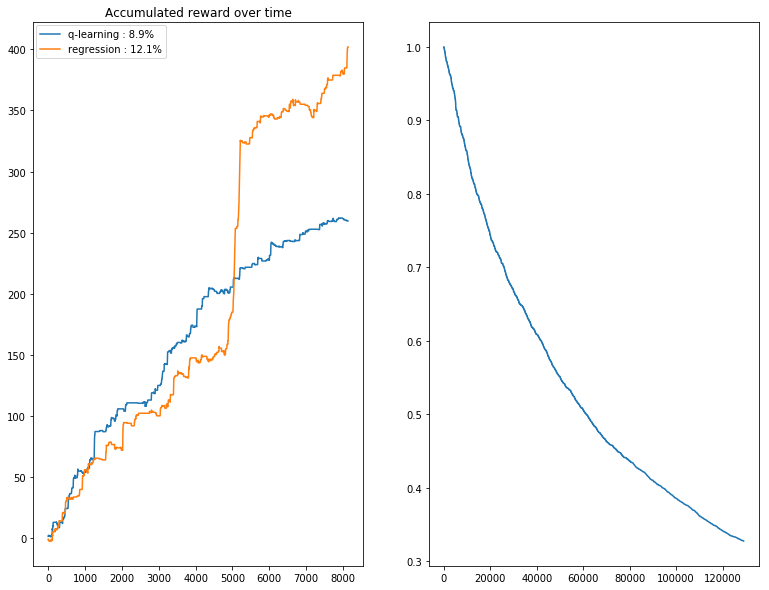

In [18]:
plot(algo_Q, algo_R)